## Titanic - Who did survive?

### 1. Introduction


This small project is part of the Udacity Nanodegree "Data Analyst" were I basically try to familiarize myself with the Pandas, Numpy and Seaborn libraries. For this, **I visually investigate how victims and survivors of the Titanic's sinking differ in several terms including socio-economic status, age, and gender**. To my mind, the Titanic dataset is a good starting point to get ones head around Python because it is clean and simply structured. The focus for this project lies on some basic data wrangling, exploring tasks, and test statistics. Lastly, I'm a R user and this is my first ever Python script so do not expect anything to fancy and bare with me I guess. 

### 2. First Glance

First things first, let's import the required packages, read the data, and take a first look at things such as dimensions, variable types, coding, etc. to get a sense of the dataset.

In [106]:
# import packages
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [107]:
# read csv. as dataframe
tit = pd.read_csv("titanic_train.csv")

In [108]:
# take a look at the first 5 rows
tit.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [109]:
# take a look at variable types and dimensions
tit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Next, I take a quick look at the distribution of each variable. Describe() is a pretty neat function in this regard. For getting meaningful results for factor variables, transforming them to class category is required, though. 

In [110]:
# drop useless variables
tit = tit.drop(["PassengerId", "Ticket"], 1)

# transform to factor variables 
for col in ["Survived", "Pclass", "Sex", "Embarked"]:
    tit[col] = tit[col].astype("category")
    
# transform levles of survived 
# tit['Survived'].replace({0:'Died', 1:'Survived'}, inplace = True)
# issues with plots later on thus just change plots visuals directly

In [111]:
# summary of numeric variables
tit.describe(include = [np.number])

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [112]:
# summary of non-numeric variables 
tit.describe(exclude = [np.number])

,Survived,Pclass,Name,Sex,Cabin,Embarked
count,891,891,891,891,204,889
unique,2,3,891,2,147,3
top,0,3,"Salonen, Mr. Johan Werner",male,B96 B98,S
freq,549,491,1,577,4,644


### 3. Missing Values

Let’s take a look if missing values are much of an issue. As seen below, there are quite a few missing observations for age. Besides, cabin becomes pretty much useless due to the high number of NAs which is a shame because the deck on which people stayed probably was an influential factor. Lastly, embarked has also two missing values. 

In [113]:
# check NAs
tit.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

I won't do any imputation for "cabin" because there simply are to many NAs to get reliable values to my mind. For the two missing observations of "embarked" we probably can figure the right port out, assuming that the fare pretty much only differs across port of embarkation and booked class. First, let's take a closer look at the two missing observations. 

In [114]:
# closer look at embark NAs
tit[tit.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,B28,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,B28,NaN


As seen above, we do know the payed fare as well as the booked class. Thus, all there is left to do is checking the median fares for first class passengers grouped by port of embarkation. I choose the median instead of the mean due to the skeewed distribution of fare. So we see that Cherbourg matches pretty well which I therefore use as replacement.

In [115]:
# filter class 1
tit_c1 = tit.query('Pclass == 1')
# get median grouped by embarked
tit_c1.groupby('Embarked').agg({'Fare': 'median'})

,Fare
Embarked,
C,78.2667
Q,90.0000
S,52.0000


In [116]:
# replace with C
tit = tit.set_value(tit.Embarked.isnull(), 'Embarked', 'C')

Lastly, let's take care of age. The easiest approach would be to simply replace all missing values with the mean of age. A more appropiate way is to actually predict the missing values based on the values of the other variables. I planned to do the latter using KNN. R provides the "mice" package and "fancyimpute" seems to be Python's equivalent to do the job. However, I was not able to install the library because apparently Anaconda was not able to "find a version that satisfies the requirements". Therefore let's take a third approach, that is I used distinct passenger groups and calculate seperate age medians.

In [117]:
# replace NAs of age with mean
# tit['Age'].fillna((tit['Age'].mean()), inplace = True)

# replace with median by sex and class
tit.loc[:, "Age"] = tit.groupby(["Sex","Pclass"]).transform(lambda x: x.fillna(x.median()))

### 4. Creating New Variables

While there already are quiet a few interesting variables, I do include three additional ones. Namely, the title - mainly measuring if women were married, the size of the family - which is a clearer version of "parch" and "sibsp", and an improved version of "sex" that adds the level children to the provided gender variable. Those variables seem to be pretty standard on Kaggle.

In [118]:
# extract title from name
tit["Title"] = tit["Name"].str.split(',', 1, expand = True)[1].str.split('.', 1, expand = True)[0]
tit['Title'] = tit['Title'].astype("category")

In [119]:
# transform to 4-level factor
tit['Title'] = np.where(tit["Title"].str.contains("Miss"), "Miss",
                np.where(tit["Title"].str.contains("Mrs"), "Mrs",
                 np.where(tit["Title"].str.contains("Mr"), "Mr", "rare")))

In [137]:
# create family size
tit["Fam_size"] = tit["SibSp"] + tit["Parch"] + 1

# transform to 4-level factor
tit["Fam_size"] = pd.cut(tit["Fam_size"], bins=[0,1,3,5,15], labels=["Single", "Small Family", "Medium Family", "Large Family"])
tit["Fam_size"] = tit["Fam_size"].astype("category")

# family size 2
tit["Fam_size2"] = tit["SibSp"] + tit["Parch"] + 1
tit["Fam_size2"] = pd.cut(tit["Fam_size2"], bins=[0,1,15], labels=["Single", "Family"])
tit["Fam_size2"] = tit["Fam_size2"].astype("category")

In [121]:
# add child to gender variable
tit["Who"] = np.where(tit["Age"] < 17, "Child",
               np.where(tit["Sex"].str.contains("female"), "Women", "Man"))
tit["Who"] = tit["Who"].astype("category")

In [150]:
# factorize age variable
tit["age_group"] = pd.cut(tit["Age"], bins =[0, 12, 18, 60, np.inf], labels =["child", "teenager", "adult", "elder"])
tit["age_group"] = tit["age_group"].astype("category")

### 5. Plotting - Who Took the Trip?

Before I tackle the question who survived let's take a quick look at Titanic's passengers in general. In short, we see that most of them were male adults who traveled alone in the third class.

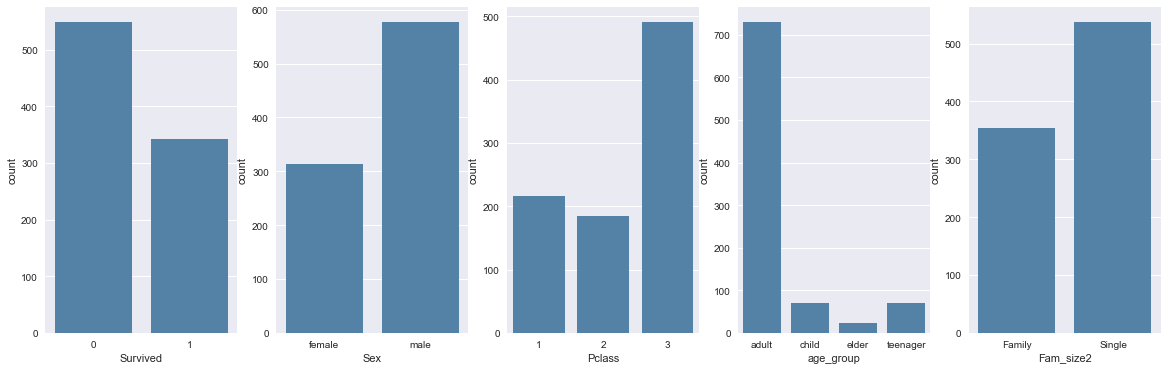

In [151]:
f, ax = plt.subplots(1,5,figsize = (20,6))
sns.countplot(tit['Survived'], ax = ax[0], color = "steelblue")
sns.countplot(tit['Sex'], ax = ax[1], color = "steelblue")
sns.countplot(tit['Pclass'], ax = ax[2], color = "steelblue")
sns.countplot(tit['age_group'], ax = ax[3], color = "steelblue")
sns.countplot(tit['Fam_size2'], ax = ax[4], color = "steelblue")
plt.show()

### 6. Plotting - Who Survived?

As shown below one may uses tables to answer the question who survived. Here, for example one clearly sees that unsurprisingly **much more lower class passenger died then high class passengers**. 

In [140]:
# example crosstab with percentages 
pd.crosstab(tit.Survived, tit.Pclass, normalize= 1)

Pclass,1,2,3
Survived,,,
0,0.37037,0.527174,0.757637
1,0.62963,0.472826,0.242363


The first thing that comes to my mind when thinking about the Titanic is the good old principle **"women and children first"** which according to the plot below seems to **holds true**. More then 80 percent of all men died. On the contrary, about 70 percent of the women and 55 percent of the children survived the sinking.

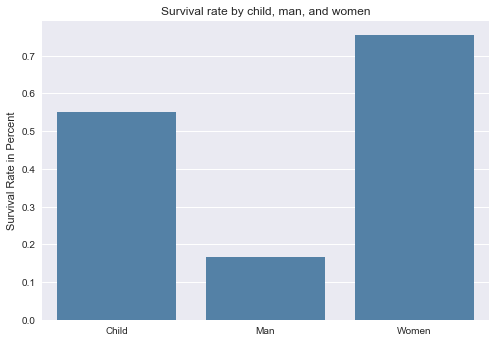

In [125]:
# apparently I need to transform it back to integer to use seaborn properly.
tit["Survived"] = tit["Survived"].astype("int")
 
p1 = sns.barplot(x = "Who", 
                 y = "Survived", 
                 data = tit, 
                 color= "steelblue",
                 ci = None)
p1.set_xlabel('')    
p1.set_ylabel('Survival Rate in Percent')
p1.set_title('Survival rate by child, man, and women')
sns.plt.show()

However, if ones take a closer look we can see a more detailed pattern. Across all three classes it still holds true that women and children had better chances of survival then men, though the proportions differ somewhat across classes. More precicely, we see that **the survival rate between women and men differs the most in the second class**. Besides, the plot shows that **third-class women and children were much more likely to die then their upper-class counterparts**. Put differently, we may want to adjust the priciple a bit and just call it women and children first especially if they are wealthy.

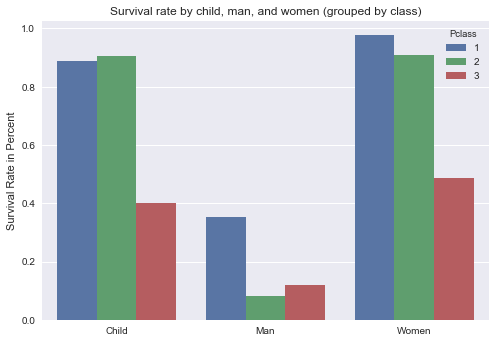

In [126]:
p2 = sns.barplot(x = "Who", 
                 y = "Survived", 
                 hue = "Pclass", 
                 data = tit,
                 ci = None)
p2.set_xlabel('')    
p2.set_ylabel('Survival Rate in Percent')
p2.set_title('Survival rate by child, man, and women (grouped by class)')
sns.plt.show()

Next, how about our newly cretaed variable family size? Where you better of as lone wolf or was the pack more likely to survive?

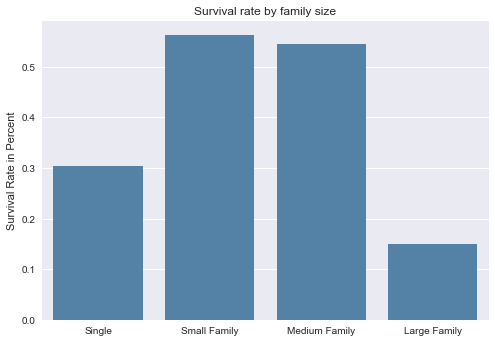

In [127]:
p3 = sns.barplot(x = "Fam_size", 
                 y = "Survived", 
                 data = tit, 
                 color= "steelblue", 
                 order = ["Single", "Small Family", "Medium Family", "Large Family"],
                 ci = None)
p3.set_xlabel('')    
p3.set_ylabel('Survival Rate in Percent')
p3.set_title('Survival rate by family size')
sns.plt.show()

Seems that **singles and large families did struggle to survive the catastrophe**. Why is that though? I can think of a couple of reason for this pattern. First, people traveling alone may be predominantly men and regarding large families, I picture dozens of poor Irish extended families in the third class. So let's check this out then.

In [128]:
# creaty dummy if family size is single
tit["sdummy"] = tit["Fam_size"].str.contains("Single")
# filter tit 
tit_temp = tit.query('sdummy == True')
# check distribution
pd.crosstab(index = tit_temp.Who, columns ="count")   

col_0,count
Who,
Child,16
Man,403
Women,118


In [129]:
# creaty dummy if family size is large
tit["ldummy"] = tit["Fam_size"].str.contains("Large")
tit["ldummy"].describe()
# filter tit 
tit_temp = tit.query('ldummy == True')
# check distribution
pd.crosstab(index = tit_temp.Pclass, columns = "count")   

col_0,count
Pclass,
1,4
2,1
3,42


It indeed does seem that my above stated hunches are true since about 75 percent of the singles are men and almost all large families are booked in the third class. Ok, let's investigate the role of the fare now. Fare probably captures pretty much the same information as passenger class, though it gives me the option to mix plot types up a bit. As seen below, unsurprisingly, **people who survived did pay on average more for their tickets**.

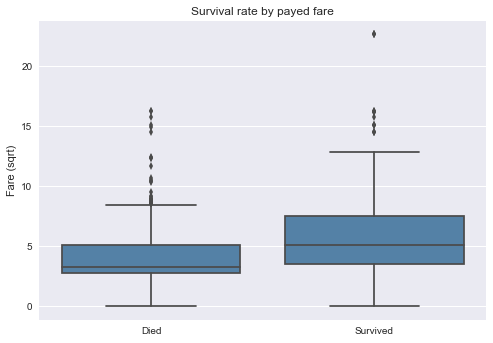

In [130]:
# tranform due to skewness 
tit['Fare_log'] = np.sqrt(tit["Fare"])

p4 = sns.boxplot(x = "Survived", 
                 y = "Fare_log", 
                 data = tit,
                 color= "steelblue")
p4.set_ylabel("Fare (sqrt)")
p4.set_xlabel("")
p4.set_title("Survival rate by payed fare")
p4.set(xticklabels=["Died", "Survived"])

sns.plt.show()

Lastly, let's explore the influence of the passengers's age. An overlapping density plot might be helpfull to illustrate potential patterns. As indicated below we see that while **people up to the age of about 11 were more likely to survive, passenger aged between 15 and 30 had rather bad chances**. Note, that I found the code snippet on Kaggle because I had some issues getting a nice looking overlaying density plot with seaborn at the start. Also note, that the plot is biased due to the bad imputation beforehand...Still looking for a way to implement KNN imputation in Python.

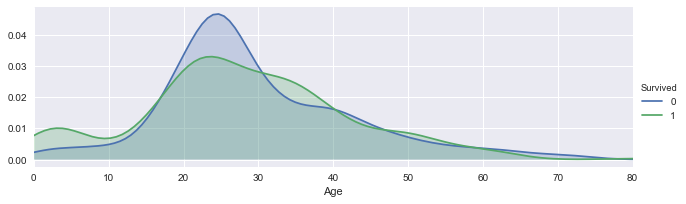

In [131]:
facet = sns.FacetGrid(tit, hue="Survived",aspect=3)
facet.map(sns.kdeplot, 'Age',shade = True)
facet.set(xlim=(0, tit['Age'].max()))
facet.add_legend()
sns.plt.show()

Another appraoch might be to group passengers into several age related categories. The following code does this job using the cut() function again.

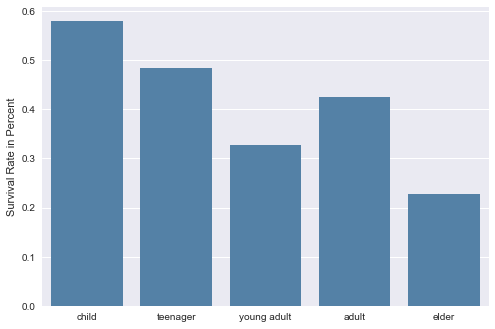

In [132]:
tit["age_group"] = pd.cut(tit["Age"], bins =[0, 12, 16, 30, 60, np.inf], labels =["child", "teenager", "young adult", "adult", "elder"])
tit['age_group'] = tit['age_group'].astype("category")

p5 = sns.barplot(y = "Survived", 
                 x = "age_group", 
                 data = tit,
                 color= "steelblue",
                 order = ["child", "teenager", "young adult", "adult", "elder"],
                 ci = None)
p5.set_xlabel('')    
p5.set_ylabel('Survival Rate in Percent')
sns.plt.show()

### 7. Bivariate Statistical Tests - Who Survived?

Finally, let's check whether some groups had a statistically significant higher survival rate than others. This takes the analysis away from the purely explorative level and adds some simple hypothesis testing. In order to do so we need the Pearson's chi-squared test (or Fischers if some levels are really scare). This test basically evaluates how likely it is that any observed difference between two categorial variables arose by chance. Put differently, we test if "Survived" and a second variable such as "Pclass" are independent, that is, if the probability distribution of "Survived" is not affected by the presence of "Pclass".

Since this is rather illustrative I run only tests for the three variables "Pclass", "Sex", and "age_group". As the p-value is  for all three tests much smaller than the .05 significance level, I do reject the null hypothesis that class/sex/age are independent of the survival of a passenger. 

Note that the tests so far only tells us that the variables are related. It does not tell us how strongly they are related or if the relation is spurious. 

In [133]:
# create cross-tab survived and passenger class
spc = pd.crosstab(tit.Survived, tit.Pclass)
# get chi2, degrees of freedom, p-value, and expected
chi2, p, ddof, expected = scipy.stats.chi2_contingency( spc  )
# create empty output pattern
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
# print values in output pattern
print( msg.format( chi2, p, ddof ) )

Test Statistic: 102.88898875696056
p-value: 4.549251711298793e-23
Degrees of Freedom: 2



In [134]:
# create cross-tab survived and passenger age group
sag = pd.crosstab(tit.Survived, tit.age_group)
# get chi2, degrees of freedom, p-value, and expected
chi2, p, ddof, expected = scipy.stats.chi2_contingency( sag  )
# create empty output pattern
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
# print values in output pattern
print( msg.format( chi2, p, ddof ) )

Test Statistic: 23.30121021360333
p-value: 0.0001102345644704154
Degrees of Freedom: 4



In [135]:
# create cross-tab survived and passenger age group
ss = pd.crosstab(tit.Survived, tit.Sex)
# get chi2, degrees of freedom, p-value, and expected
chi2, p, ddof, expected = scipy.stats.chi2_contingency( ss  )
# create empty output pattern
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
# print values in output pattern
print( msg.format( chi2, p, ddof ) )

Test Statistic: 260.71702016732104
p-value: 1.1973570627755645e-58
Degrees of Freedom: 1



### 8. Summary and Limitations
I found that basically all variables differ for those passengers who survived and those who did not. The latter seemed often to be **young male lower class passengers who traveled alone**. It is obvious though, that all the variables are highly connected. 

I'm pretty dissatisfied with the way I imputed age so far. Besides, the data lacks any informations about the crew. Regarding the next step a proper carfully modeled logistic regression would be interestting to see which factors really matter and how they are connected - or just do some predictive modeling. 

Regarding Python, so far it seems to me that Pandas/Seaborn does not have to hide behind R's Tidyverse package canon. In fact, it seems to be pretty neat. Therefore I’m looking forward to more advanced plotting, data wrangling stuff, to write some functions, and to do some modeling to see how I get to grips with Python. The only thing that really annoys me is that compared to R Studio Jupyter Notebook and Spyder seem to be really bad. Still hoping to find an alternative. 